[*********************100%***********************]  1 of 1 completed
<START> Brokerage account: $10000.00
2016-11-16, Buy Create, 27.50
2016-11-17, Executed BUY (Price: 27.45, Value: 274.52, Commission 0.27)
2016-11-23, Position Closed, 27.81
2016-11-25, Executed SELL (Price: 27.78, Value: 274.52, Commission 0.28)
2016-12-01, Sell Create, 27.37
2016-12-02, Executed SELL (Price: 27.29, Value: -272.92, Commission 0.27)
2016-12-08, Position Closed, 28.03
2016-12-09, Executed BUY (Price: 28.08, Value: -272.92, Commission 0.28)
2017-06-16, Sell Create, 35.57
2017-06-19, Executed SELL (Price: 35.92, Value: -359.15, Commission 0.36)
2017-06-23, Position Closed, 36.57
2017-06-26, Executed BUY (Price: 36.79, Value: -359.15, Commission 0.37)
2017-06-27, Sell Create, 35.93
2017-06-28, Executed SELL (Price: 36.12, Value: -361.23, Commission 0.36)
2017-07-05, Position Closed, 36.02
2017-07-06, Executed BUY (Price: 35.76, Value: -361.23, Commission 0.36)
2017-07-10, Buy Create, 36.26
2017-07-11, Exe

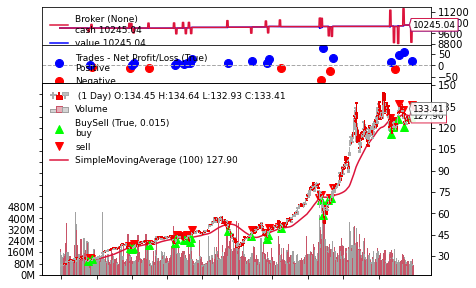

In [3]:
import backtrader as bt
import yfinance as yf
from matplotlib import warnings

class MAstrategy(bt.Strategy):
	# when initializing the instance, create a 100-day MA indicator using the closing price
	def __init__(self):
		self.ma = bt.indicators.SimpleMovingAverage(self.data.close, period=100)
		self.order = None
 
	def next(self):
		if self.order:
			return
		if not self.position: # check if you already have a position in the market
			if (self.data.close[0] > self.ma[0]) & (self.data.close[-1] < self.ma[-1]):
				self.log('Buy Create, %.2f' % self.data.close[0])
				self.order = self.buy(size=10) # buy when closing price today crosses above MA.
			if (self.data.close[0] < self.ma[0]) & (self.data.close[-1] > self.ma[-1]):
				self.log('Sell Create, %.2f' % self.data.close[0])
				self.order = self.sell(size=10)  # sell when closing price today below MA
		else:
		# This means you are in a position, and hence you need to define exit strategy here.
			if len(self) >= (self.bar_executed + 4):
				self.log('Position Closed, %.2f' % self.data.close[0])
				self.order = self.close()
 
	# outputting information
	def log(self, txt):
		dt=self.datas[0].datetime.date(0)
		print('%s, %s' % (dt.isoformat(), txt))
   
	def notify_order(self, order):
		if order.status == order.Completed:
			if order.isbuy():
				self.log(
				"Executed BUY (Price: %.2f, Value: %.2f, Commission %.2f)" %
				(order.executed.price, order.executed.value, order.executed.comm))
			else:
				self.log(
				"Executed SELL (Price: %.2f, Value: %.2f, Commission %.2f)" %
				(order.executed.price, order.executed.value, order.executed.comm))
			self.bar_executed = len(self)
		elif order.status in [order.Canceled, order.Margin, order.Rejected]:
			self.log("Order was canceled/margin/rejected")
		self.order = None

if __name__ == '__main__':
	# Create a cerebro instance, add our strategy, some starting cash at broker and a 0.1% broker commission
	cerebro = bt.Cerebro()
	cerebro.addstrategy(MAstrategy)
	cerebro.broker.setcash(10000)
	cerebro.broker.setcommission(commission=0.001)
	data = bt.feeds.PandasData(dataname=yf.download("AAPL", "2016-6-25", "2021-6-25"))
	cerebro.adddata(data)
   
	print('<START> Brokerage account: $%.2f' % cerebro.broker.getvalue())
	cerebro.run()
	print('<FINISH> Brokerage account: $%.2f' % cerebro.broker.getvalue())
	%matplotlib inline
	# Plot the strategy
	cerebro.plot(style='candlestick',loc='grey', grid=False, iplot=False) #You can leave inside the paranthesis empty